In [1]:
#!git clone https://github.com/KayoRBC/TCC.git

In [2]:
from reportlab.rl_settings import verbose
!pip install pandas yfinance numpy matplotlib scikit-learn tensorflow requests joblib pytz python-dateutil pmdarima keras-tuner

Defaulting to user installation because normal site-packages is not writeable


In [3]:
import os
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense
import tensorflow as tf
from pandas import DataFrame
import requests
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import joblib
from datetime import datetime, timedelta
import pytz
from dateutil.relativedelta import relativedelta

from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
import joblib as jl

from pmdarima import auto_arima
import warnings

from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler

2024-10-24 20:40:36.167817: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-24 20:40:36.172383: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-24 20:40:36.186933: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-24 20:40:36.210434: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-24 20:40:36.217314: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-24 20:40:36.234874: I tensorflow/core/platform/cpu_feature_gu

In [4]:
# utils
warnings.filterwarnings("ignore")

def show_history_details(ticker_history: DataFrame):
    print(f"Size: {len(ticker_history)}")
    print(f"Min date: {ticker_history.index.min()}")
    print(f"Max date: {ticker_history.index.max()}")

def filter_per_date(history: DataFrame, min_date, max_date):
    a = history[(history.index >= min_date) & (history.index <= max_date)]
    return a


def get_first(dict_tickers_history: dict):
    return next(iter(dict_tickers_history.values()))


def show_details(dict_tickers_history: dict):
  print(f"Qtd Tickers: {len(dict_tickers_history.keys())}")
  first = get_first(dict_tickers_history)
  print(f"Fist History size: {len(first)}")
  print(f"Fist Min date: {first.index.min()}")
  print(f"Fist Max date: {first.index.max()}")
  

def plot_arima_results(train_history: DataFrame, test_history: DataFrame, dict_pred: dict):
    # Criando o gráfico
    plt.figure(figsize=(10,6))
    plt.plot(train_history.index, get_prices(train_history), label='Todo treino')
    plt.plot(test_history.index, get_prices(test_history), label='Todo teste')
    
    for periodo, pred in dict_pred.items():
        plt.plot(pred.index, pred.values, label=f'Treino com {periodo}')
    
    # Adicionando rótulos e título
    plt.xlabel('Data')
    plt.ylabel('Valores')
    plt.title('Comparação de predições entre diferentes períodos de treino')
    plt.legend()
    
    # Exibindo o gráfico
    plt.grid(True)
    plt.xticks(rotation=45)  # Rotacionar as datas para melhor visualização
    plt.tight_layout()  # Ajustar espaçamento
    plt.show()

## Seleção das ações

Para pegar os nomes das ações listadas na B3, fizemos o download de um csv no site https://www.dadosdemercado.com.br/acoes.

In [5]:
def get_b3_ticker_symbols() -> list:
    """
    download do csv nesse link: https://www.dadosdemercado.com.br/acoes
    """
    tickers_df = pd.read_csv('acoes-listadas-b3.csv')
    return tickers_df['Ticker'].tolist()

lst_b3_ticker_symbol = get_b3_ticker_symbols()
print(lst_b3_ticker_symbol)

['LREN3', 'B3SA3', 'HAPV3', 'PETR4', 'ENEV3', 'EMBR3', 'ITUB4', 'AZUL4', 'BBDC4', 'ABEV3', 'ITSA4', 'ASAI3', 'COGN3', 'PETZ3', 'PETR3', 'VALE3', 'BBAS3', 'CPLE6', 'RDOR3', 'CSAN3', 'STBP3', 'MGLU3', 'CMIG4', 'GGBR4', 'IFCM3', 'POMO4', 'CXSE3', 'ELET3', 'RENT3', 'RAIL3', 'WEGE3', 'CMIN3', 'VBBR3', 'CVCB3', 'CCRO3', 'UGPA3', 'TIMS3', 'NTCO3', 'RAIZ4', 'QUAL3', 'EQTL3', 'RADL3', 'JBSS3', 'USIM5', 'FLRY3', 'CSNA3', 'SUZB3', 'CRFB3', 'AMER3', 'RRRP3', 'CPLE3', 'AURE3', 'BBDC3', 'HBSA3', 'DXCO3', 'BEEF3', 'SBSP3', 'PRIO3', 'BBSE3', 'BRFS3', 'ONCO3', 'ALOS3', 'MRVE3', 'PCAR3', 'YDUQ3', 'GOLL4', 'GGPS3', 'VAMO3', 'MLAS3', 'TOTS3', 'AZEV4', 'VVEO3', 'BHIA3', 'HYPE3', 'ECOR3', 'CYRE3', 'GOAU4', 'BRKM5', 'VIVT3', 'VIVA3', 'MULT3', 'LWSA3', 'ALPA4', 'OPCT3', 'AZZA3', 'ANIM3', 'BRAP4', 'MRFG3', 'CPFE3', 'JHSF3', 'SIMH3', 'RANI3', 'MOVI3', 'CLSA3', 'SRNA3', 'CURY3', 'POSI3', 'RAPT4', 'ELET6', 'AESB3', 'EGIE3', 'RECV3', 'MATD3', 'DIRR3', 'GFSA3', 'LJQQ3', 'SMFT3', 'BPAN4', 'SAPR4', 'CBAV3', 'TEND3', 

Agora que temos os nomes das ações, iremos fazer o download de todo o histórico delas até o dia 28/12/2023 com a yfinance. Não pegamos os dados de 2024 pois é o ano que estamos realizando este trabalho e mais para frente queremos selecionar um período que contemple cada ano inteiramente. Além disso, pegamos até o dia 28/12 pois é o último dia com histórico do ano de 2023.

In [6]:
max_history_date = "2023-12-28"

def somar_um_dia(date: str) -> str:
    data = datetime.strptime(date, "%Y-%m-%d")
    date = data + timedelta(days=1)
    return date.strftime("%Y-%m-%d")


def download_tickers_history(lst_ticker_symbols: list, max_history_date: str) -> dict:
    # precisamos adicionar '.SA' no final de cada ticker pois é assim que o yfinance espera
    df_tickers = yf.download(".SA ".join(lst_ticker_symbols) + ".SA", end=somar_um_dia(max_history_date), group_by="ticker")
    dict_tickers = {}
    for ticker_symbol in set([t[0] for t in df_tickers.keys()]):
        dict_tickers[ticker_symbol] = df_tickers[ticker_symbol].dropna()
    return dict_tickers


dict_tickers_history = None
if (os.path.exists("dict_tickers_history.pkl")):
    dict_tickers_history = jl.load("dict_tickers_history.pkl")
else:
    dict_tickers_history = download_tickers_history(lst_b3_ticker_symbol, max_history_date)
    jl.dump(dict_tickers_history, "dict_tickers_history.pkl")

next(iter(dict_tickers_history.values())).head()

Price,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-05 00:00:00+00:00,211.000000,220.000000,211.000000,211.000000,62.120045,0.0
2000-01-06 00:00:00+00:00,221.089996,221.089996,221.089996,221.089996,65.090622,28.0
2000-01-07 00:00:00+00:00,221.089996,221.089996,221.089996,221.089996,65.090622,0.0
2000-01-10 00:00:00+00:00,221.089996,221.089996,221.089996,221.089996,65.090622,0.0
2000-01-11 00:00:00+00:00,221.089996,221.089996,221.089996,221.089996,65.090622,0.0


Como podemos ver acima, essas são as informações fornecidas pela yfinance. Agora iremos filtrar as ações que tenham no mínimo 10 anos de histórico até o dia 28/12/2023

In [7]:


def filter_tickers_history_by_age(dict_tickers_history: dict, max_history_date: str, min_age_in_years: int) -> dict:
    dict_tickers = {}
    min_history_date = pytz.utc.localize(datetime.strptime(max_history_date, "%Y-%m-%d")) - relativedelta(years=min_age_in_years)
    for t, history in dict_tickers_history.items():
        if not history.empty and history.index.min() < min_history_date:
            dict_tickers[t] = history
    return dict_tickers

dict_tickers_history = filter_tickers_history_by_age(dict_tickers_history, max_history_date, min_age_in_years=10)

print(f"Quantidade de ações: {len(dict_tickers_history)}")

Quantidade de ações: 289


Agora iremos pegar os 100 com maior volume no dia 28/12/2023

In [8]:
def filter_tickers_by_volume(dict_tickers_history: dict, date_filter: str, top: int) -> dict:
    return dict(sorted(dict_tickers_history.items(), key=lambda item: item[1].loc[date_filter, 'Volume'], reverse=True)[:top])

dict_tickers_history = filter_tickers_by_volume(dict_tickers_history, date_filter=max_history_date, top=100)
print(f"Total de tickers: {len(dict_tickers_history)}")
print(f"{'Posição':>3}   {'Ticker Symbol':<13}   {'Volume':>10}")
print("-" * 30)
i = 0    
for ticker, history in dict_tickers_history.items():
    i += 1
    volume = history.loc[max_history_date, "Volume"]
    print(f"{i}   {ticker:<13}   {volume:>10,.2f}")

Total de tickers: 100
Posição   Ticker Symbol       Volume
------------------------------
1   CVCB3.SA        71,001,900.00
2   EMBR3.SA        25,890,400.00
3   ITSA4.SA        23,414,900.00
4   PETR4.SA        21,421,900.00
5   CIEL3.SA        20,929,200.00
6   B3SA3.SA        20,491,200.00
7   VALE3.SA        16,545,800.00
8   ABEV3.SA        16,500,300.00
9   BBDC4.SA        14,852,700.00
10   COGN3.SA        14,615,200.00
11   GFSA3.SA        13,601,100.00
12   MRVE3.SA        13,504,400.00
13   CMIG4.SA        13,371,410.00
14   MGLU3.SA        12,859,371.00
15   ITUB4.SA        12,555,300.00
16   TRPL4.SA        12,457,500.00
17   PETR3.SA        11,746,400.00
18   LREN3.SA        11,687,800.00
19   BBAS3.SA        11,680,800.00
20   POMO4.SA        11,418,400.00
21   CPLE3.SA        11,054,700.00
22   ALPA4.SA        10,988,900.00
23   CPLE6.SA        9,721,200.00
24   ENEV3.SA        9,185,800.00
25   PDGR3.SA        8,253,900.00
26   FLRY3.SA        8,182,700.00
27   PRIO3.SA

## Tratamento dos dados

Iremos filtrar apenas os 10 anos de histórico.

In [9]:
def cut_tickers_history(dict_tickers_history: dict, max_history_date: str, years_to_intact: int) -> dict:
  data_min = pytz.utc.localize(datetime.strptime(max_history_date, "%Y-%m-%d")) - relativedelta(years=years_to_intact)
  for t, history in dict_tickers_history.items():
    dict_tickers_history[t] = history[history.index > data_min]
  return dict_tickers_history

print("Antes: ")
show_details(dict_tickers_history)
dict_tickers_history = cut_tickers_history(dict_tickers_history, max_history_date, years_to_intact=10)
print("\nDepois: ")
show_details(dict_tickers_history)

Antes: 
Qtd Tickers: 100
Fist History size: 2498
Fist Min date: 2013-12-09 00:00:00+00:00
Fist Max date: 2023-12-28 00:00:00+00:00

Depois: 
Qtd Tickers: 100
Fist History size: 2485
Fist Min date: 2013-12-30 00:00:00+00:00
Fist Max date: 2023-12-28 00:00:00+00:00


 Deixar apenas as colunas da data (Date) e o último valor da ação no dia (Close) 

In [10]:
for ticker, history in dict_tickers_history.items():
    dict_tickers_history[ticker] = DataFrame(history["Close"])

next(iter(dict_tickers_history.values())).head()

,Close
Date,
2013-12-30 00:00:00+00:00,12.610100
2014-01-02 00:00:00+00:00,12.898567
2014-01-03 00:00:00+00:00,13.104614
2014-01-06 00:00:00+00:00,13.187033
2014-01-07 00:00:00+00:00,13.187033


Agora iremos separar 50% dos dados para treino e 50% para teste

In [11]:
def split_train_test(dict_tickers_history: dict, train_size: float) -> tuple[dict, dict]:
  train = {}
  test = {}
  for t, h in dict_tickers_history.items():
    limiar = int(len(h) * train_size)
    train[t] = h.iloc[:limiar]
    test[t] = h.iloc[limiar:]
  return train, test

dict_train_history, dict_test_history = split_train_test(dict_tickers_history, train_size = 0.5)
print("Train")
show_details(dict_train_history)
print("-"*30)
print("Test")
show_details(dict_test_history)

Train
Qtd Tickers: 100
Fist History size: 1242
Fist Min date: 2013-12-30 00:00:00+00:00
Fist Max date: 2018-12-26 00:00:00+00:00
------------------------------
Test
Qtd Tickers: 100
Fist History size: 1243
Fist Min date: 2018-12-27 00:00:00+00:00
Fist Max date: 2023-12-28 00:00:00+00:00


Iremos separar os dados de treinamento em 6 períodos. Isso para observar também como a quantidade de dados de treinamento impacta na predição nos modelos.

In [12]:
def separar_train_em_periodos(history) -> dict:
    max_date = history.index.max()
    return {
        "1 mês": filter_per_date(history, min_date=max_date - pd.DateOffset(months=1), max_date=max_date),
        "3 meses": filter_per_date(history, min_date=max_date - pd.DateOffset(months=3), max_date=max_date),
        "6 meses": filter_per_date(history, min_date=max_date - pd.DateOffset(months=6), max_date=max_date),
        "1 ano": filter_per_date(history, min_date=max_date - pd.DateOffset(years=1), max_date=max_date),
        "3 anos": filter_per_date(history, min_date=max_date - pd.DateOffset(years=3), max_date=max_date),
        "5 anos": filter_per_date(history, min_date=max_date - pd.DateOffset(years=5), max_date=max_date)
    }

dict_train_periods = dict()
for ticker, history in dict_train_history.items():
    dict_train_periods[ticker] = separar_train_em_periodos(history)

exemplo = get_first(dict_train_periods)
for periodo, history in exemplo.items():
    print(30 * "-")
    print(periodo)
    show_history_details(history)

------------------------------
1 mês
Size: 21
Min date: 2018-11-26 00:00:00+00:00
Max date: 2018-12-26 00:00:00+00:00
------------------------------
3 meses
Size: 60
Min date: 2018-09-26 00:00:00+00:00
Max date: 2018-12-26 00:00:00+00:00
------------------------------
6 meses
Size: 124
Min date: 2018-06-26 00:00:00+00:00
Max date: 2018-12-26 00:00:00+00:00
------------------------------
1 ano
Size: 248
Min date: 2017-12-26 00:00:00+00:00
Max date: 2018-12-26 00:00:00+00:00
------------------------------
3 anos
Size: 750
Min date: 2015-12-28 00:00:00+00:00
Max date: 2018-12-26 00:00:00+00:00
------------------------------
5 anos
Size: 1242
Min date: 2013-12-30 00:00:00+00:00
Max date: 2018-12-26 00:00:00+00:00


Como o ARIMA tira melhor proveito de dados estacionários e o LSTM de dados normalizados, iremos deixar os dados de treinamento em ambos os estados. Assim dando vantagem para nenhum dos modelos

In [18]:
# Função para verificar se uma série é estacionária usando o teste ADF
def is_stationary(series, alpha=0.05):
    try:
        result = adfuller(series)
        p_value = result[1]
        return p_value < alpha  # Retorna True se a série é estacionária
    except ValueError:
        return True
    
# Função para tornar a série estacionária aplicando diferenciações
def make_stationary(df, column):
    series = df[column]
    d = 0  # Número de diferenciações aplicadas
    # Diferencia a série até que ela seja estacionária
    while not is_stationary(series) and d < 5:  # Limite de 5 diferenciações para evitar excesso
        series = series.diff().dropna()
        d += 1
    return series, d

# Função para normalizar a série utilizando MinMaxScaler
def normalize_series(series):
    scaler = MinMaxScaler()
    # Redimensiona a série para a forma adequada para o scaler (n_samples, n_features)
    series_normalized = scaler.fit_transform(series.values.reshape(-1, 1))
    return series_normalized.flatten(), scaler


dict_train_periods_tratada = dict()

# Itera sobre o dicionário e torna as séries estacionárias e normalizadas
for ticker, dict_periodo in  dict_train_periods.items():
    for periodo, history in dict_periodo.items():
        if not dict_train_periods_tratada.__contains__(periodo):
            dict_train_periods_tratada[periodo] = dict()
        
        print(f'Tratando historico de treino do ticker \'{ticker}\' com período de \'{periodo}\'')
        
        # Torna a série estacionária
        estacionaria, num_diffs = make_stationary(history, column='Close')
        
        # Normaliza a série estacionária
        estacionaria_normalizada, scaler = normalize_series(estacionaria)
        
        # Ajusta os índices para garantir que o comprimento corresponda ao DataFrame original    
        # Adiciona a série normalizada ao DataFrame, alinhando os índices
        history_tratada = pd.DataFrame({'Normalized_Stationary_Close': estacionaria_normalizada}, estacionaria.index)
        history_tratada['Normalized_Stationary_Close'] = history_tratada['Normalized_Stationary_Close'].reindex(history.index)
        
        dict_train_periods_tratada[periodo][ticker] = {"historico_original": history, "num_diffs": num_diffs, "scaler_normalizacao": scaler, "historico_estacionario_normalizado": history_tratada}
        
        print(f'Série para \'{ticker}\' com periodo \'{periodo}\' foi diferenciada {num_diffs} vezes e normalizada.')

Tratando historico de treino do ticker 'CVCB3.SA' com período de '1 mês'
Série para 'CVCB3.SA' com periodo '1 mês' foi diferenciada 1 vezes e normalizada.
Tratando historico de treino do ticker 'CVCB3.SA' com período de '3 meses'
Série para 'CVCB3.SA' com periodo '3 meses' foi diferenciada 0 vezes e normalizada.
Tratando historico de treino do ticker 'CVCB3.SA' com período de '6 meses'
Série para 'CVCB3.SA' com periodo '6 meses' foi diferenciada 1 vezes e normalizada.
Tratando historico de treino do ticker 'CVCB3.SA' com período de '1 ano'
Série para 'CVCB3.SA' com periodo '1 ano' foi diferenciada 1 vezes e normalizada.
Tratando historico de treino do ticker 'CVCB3.SA' com período de '3 anos'
Série para 'CVCB3.SA' com periodo '3 anos' foi diferenciada 1 vezes e normalizada.
Tratando historico de treino do ticker 'CVCB3.SA' com período de '5 anos'
Série para 'CVCB3.SA' com periodo '5 anos' foi diferenciada 1 vezes e normalizada.
Tratando historico de treino do ticker 'EMBR3.SA' com perí

In [14]:
for periodo, dict_ticker in dict_train_periods_tratada.items():
    print(f"Periodo: {periodo}")
    first_history = get_first(dict_ticker)["historico_estacionario_normalizado"]
    print(first_history.head())
    print("\n---------------------\n")

Periodo: 1 mês
                           Normalized_Stationary_Close
Date                                                  
2018-11-27 00:00:00+00:00                     1.000000
2018-11-28 00:00:00+00:00                     0.966294
2018-11-29 00:00:00+00:00                     0.303371
2018-11-30 00:00:00+00:00                     0.779777
2018-12-03 00:00:00+00:00                     0.332585

---------------------

Periodo: 3 meses
                           Normalized_Stationary_Close
Date                                                  
2018-09-26 00:00:00+00:00                     0.000000
2018-09-27 00:00:00+00:00                     0.103878
2018-09-28 00:00:00+00:00                     0.112494
2018-10-01 00:00:00+00:00                     0.089995
2018-10-02 00:00:00+00:00                     0.236477

---------------------

Periodo: 6 meses
                           Normalized_Stationary_Close
Date                                                  
2018-06-27 00:00:00+00:

Como podemos ver acima, a primeira linha ficou com valor 'NaN' pois aplicamos uma diferenciação para deixar estacionário os dados, a diferenciação consiste em calcular a diferença entre o valor atual e o anterior. E como o primeiro não tem anterior, então ficou NaN. Além disso, esse primeiro valor não vai ser utilizado no treinamento. Portanto, iremos remover essa data

In [14]:
for _, df in dict_train_history.items():
    df.drop("2013-12-30", inplace=True)
    
next(iter(dict_train_history.values())).head()

,Close,Normalized_Stationary_Close
Date,,
2014-01-02 00:00:00+00:00,12.898567,0.562415
2014-01-03 00:00:00+00:00,13.104614,0.548697
2014-01-06 00:00:00+00:00,13.187033,0.528121
2014-01-07 00:00:00+00:00,13.187033,0.514403
2014-01-08 00:00:00+00:00,13.022195,0.486969


## Predições



### Treinando e predizendo valores das ações com ARIMA e LSTM

In [16]:
max_look_back = 7

# Função para reverter a normalização
def inverse_normalization(series_normalized, scaler):
    return scaler.inverse_transform(series_normalized.reshape(-1, 1)).flatten()

# Função para reverter a diferenciação
def inverse_differencing(train_history, pred_differentiated_series, num_diffs):
    # Aplica a soma cumulativa para cada nível de diferenciação
    for _ in range(num_diffs):
        pred_differentiated_series = np.cumsum(pred_differentiated_series)
    
    last_original_price = train_history.iloc[-1]["Close"]
    # Reverte a diferenciação, somando os valores da série diferenciada ao último valor da série original
    pred_differentiated_series = pred_differentiated_series + last_original_price
    
    return pred_differentiated_series

ARIMA

In [49]:
def get_prices(history: DataFrame) -> list:
  return DataFrame(history["Normalized_Stationary_Close"]).dropna().values

def predizer_precos_com_arima(train, n_periods, max_look_back):
    arima_model = auto_arima(get_prices(train),
                        start_p=0,
                        start_q=0,
                        d=0, # já aplicamos diferenciação, por isso 0
                        max_p=max_look_back,
                        max_q=max_look_back,
                        max_d=0, # já aplicamos diferenciação, por isso 0
                        max_order=None, # retira limitacao de p,d,q
                        seasonal=False,
                        trace=False,
                        n_jobs=-1, # paralelizacao
                        error_action='ignore',suppress_warnings=True,
                        stepwise=False # optimizacao
                                     )
    arima_model = arima_model.fit(get_prices(train))
    pred = arima_model.predict(n_periods)
    return pred

def predizer_todas_as_acoes_com_arima(dict_train_periods_tratada, dict_test_history, max_look_back):
    arima_file_name = "dict_arima_pred_results.pkl"
    dict_pred = None
    if (os.path.exists(arima_file_name)):
        dict_pred = jl.load(arima_file_name)
    else:
        dict_pred = dict()
    
    progress = 0    
    for periodo, dict_tickers in dict_train_periods_tratada.items():
        if not dict_pred.__contains__(periodo):
            dict_pred[periodo] = dict()
        for ticker_name, dict_tratamentos in dict_tickers.items():
            progress += 1
            print(f"Progresso: {progress} - {ticker_name} | período: {periodo}")
            test_history = dict_test_history[ticker_name]
            if not dict_pred[periodo].__contains__(ticker_name):
                train=dict_tratamentos["historico_estacionario_normalizado"]
                lst_pred = predizer_precos_com_arima(train=train, 
                                                     n_periods=len(test_history), max_look_back=max_look_back)
                lst_pred_tratado = inverse_normalization(lst_pred, dict_tratamentos["scaler_normalizacao"])
                lst_pred_tratado = inverse_differencing(dict_tratamentos["historico_original"], lst_pred_tratado, dict_tratamentos["num_diffs"])
                dict_pred[periodo][ticker_name] =pd.DataFrame({'pred_close': lst_pred, "pred_close_tratado": lst_pred_tratado}, index=test_history.index)
                jl.dump(dict_pred, arima_file_name)
        if progress == 200:
            break
    return dict_pred

dict_arima_pred_results = predizer_todas_as_acoes_com_arima(dict_train_periods_tratada, dict_test_history, max_look_back)

Progresso: 1 - CVCB3.SA | período: 1 mês
Progresso: 2 - EMBR3.SA | período: 1 mês
Progresso: 3 - ITSA4.SA | período: 1 mês
Progresso: 4 - PETR4.SA | período: 1 mês
Progresso: 5 - CIEL3.SA | período: 1 mês
Progresso: 6 - B3SA3.SA | período: 1 mês
Progresso: 7 - VALE3.SA | período: 1 mês
Progresso: 8 - ABEV3.SA | período: 1 mês
Progresso: 9 - BBDC4.SA | período: 1 mês
Progresso: 10 - COGN3.SA | período: 1 mês
Progresso: 11 - GFSA3.SA | período: 1 mês
Progresso: 12 - MRVE3.SA | período: 1 mês
Progresso: 13 - CMIG4.SA | período: 1 mês
Progresso: 14 - MGLU3.SA | período: 1 mês
Progresso: 15 - ITUB4.SA | período: 1 mês
Progresso: 16 - TRPL4.SA | período: 1 mês
Progresso: 17 - PETR3.SA | período: 1 mês
Progresso: 18 - LREN3.SA | período: 1 mês
Progresso: 19 - BBAS3.SA | período: 1 mês
Progresso: 20 - POMO4.SA | período: 1 mês
Progresso: 21 - CPLE3.SA | período: 1 mês
Progresso: 22 - ALPA4.SA | período: 1 mês
Progresso: 23 - CPLE6.SA | período: 1 mês
Progresso: 24 - ENEV3.SA | período: 1 mês
P

In [51]:
dict_train_history["CVCB3.SA"].max()

Close    50.976128
dtype: float64

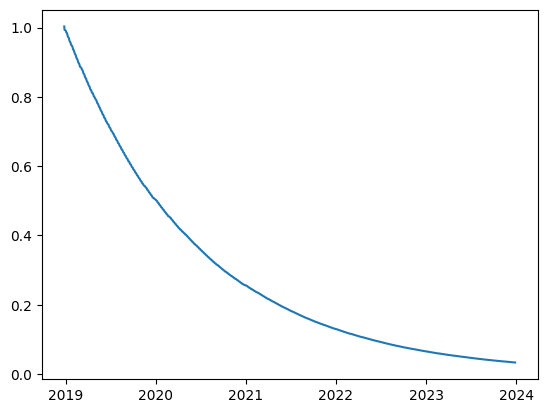

In [43]:
exemplo = get_first(dict_arima_pred_results["3 meses"])["pred_close"]
plt.plot(exemplo, label="previsto")
plt.show()

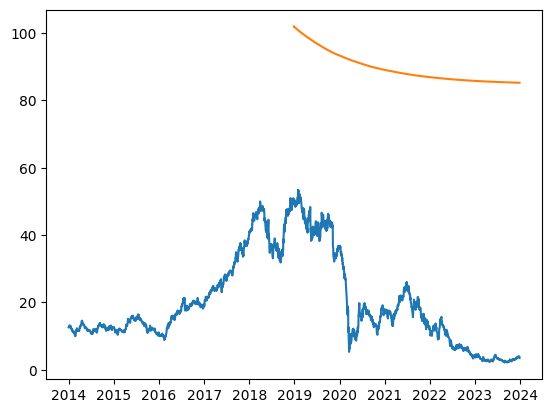

In [44]:
exemplo = get_first(dict_tickers_history)["Close"]
plt.plot(exemplo, label="original")
exemplo = get_first(dict_arima_pred_results["3 meses"])["pred_close_tratado"]
plt.plot(exemplo, label="previsto")
plt.show()

LSTM

In [ ]:
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import keras.backend as K
from keras.callbacks import EarlyStopping
import keras_tuner as kt
from tensorflow.keras.layers import Dropout
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters


def preproc(data, lag, ratio):
    data=data.dropna().iloc[:, 0:1]
    Dates=data.index.unique()
    data.iloc[:, 0] = sc.fit_transform(data.iloc[:, 0].values.reshape(-1, 1))
    for s in range(1, lag + 1):
        data['shift_{}'.format(s)] = data.iloc[:, 0].shift(s)
    X_data = data.dropna().drop(['Close'], axis=1)
    y_data = data.dropna()[['Close']]
    index=int(round(len(X_data)*ratio))
    X_data_train=X_data.iloc[:index,:]
    X_data_test =X_data.iloc[index+1:,:]
    y_data_train=y_data.iloc[:index,:]
    y_data_test =y_data.iloc[index+1:,:]
    return X_data_train,X_data_test,y_data_train,y_data_test,Dates;


def build_lstm_model(hp, look_back):
    model = Sequential()
    model.add(LSTM(hp.Int('input_unit',min_value=32,max_value=128,step=32),return_sequences=True, input_shape=(look_back,1)))
    for i in range(hp.Int('n_layers', 1, 10)):
        model.add(LSTM(hp.Int(f'lstm_{i}_units',min_value=32,max_value=128,step=32),return_sequences=True))
    model.add(LSTM(6))
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(Dense(6))
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam',metrics = ['mse'])
    return model


def predizer_precos_com_lstm(train, n_periods, max_look_back):
    a,b,c,d,e=preproc(train, lag=max_look_back, ratio=0.70)
    
    #a.head()
    
    a = a.values
    b= b.values
    c = c.values
    d = d.values

    
    tuner= kt.RandomSearch(
            build_model,
            objective='mse',
            max_trials=10,
            executions_per_trial=3
            )
    
    tuner.search(
            x=a,
            y=c,
            epochs=20,
            batch_size=128,
            validation_data=(b,d),
    )
    
    best_model = tuner.get_best_models(num_models=1)[0]
    
    y_pred = best_model.predict(b)



plt.plot(d, label = "Real data")
plt.plot(y_pred, label = "One point prediction")
plt.legend()
plt.show()



In [20]:



def split_into_X_Y_lstm(history: DataFrame, time_step: int):
  X, Y = [], []
  close = DataFrame(history["Close"])
  for i in range(len(history) - time_step):
      a = close.iloc[i:(i + time_step)].values
      X.append(a)
      Y.append(close.iloc[i + time_step].values)  # O valor que queremos prever
  return np.array(X), np.array(Y)


def create_lstm(train, n_periods, look_back):
    limiar = int(len(train) * 0.5)
    X_train, y_train = split_into_X_Y_lstm(train.iloc[:limiar], look_back)
    X_test, y_test = split_into_X_Y_lstm(train.iloc[limiar:], look_back)
    
    # Cria o modelo
    # lstm_model = Sequential()
    # lstm_model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
    # lstm_model.add(LSTM(50, return_sequences=False))
    # lstm_model.add(Dense(25))
    # lstm_model.add(Dense(1))
    # lstm_model.compile(optimizer='adam', loss='mean_squared_error')
    lstm_model = Sequential()
    lstm_model.add(LSTM(4, input_shape=(look_back, 1)))
    lstm_model.add(Dense(1))
    lstm_model.compile(loss='mean_squared_error', optimizer='adam')
    
    # Treina o modelo
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=0)
    lstm_model.fit(X_train, y_train, epochs=100, batch_size=1, validation_data=(X_test, y_test), verbose=0, callbacks=[early_stopping])
    return lstm_model
  
  
def predizer_valores_com_lstm(train, n_periods, look_back):
    time_step = int(len(train) * 0.3)
    lstm_model = create_lstm(train, time_step, look_back)    
    lst_pred = list()
    X_input = split_into_X_Y_lstm(train, time_step)[0][-1].tolist()
    for _ in range(len(n_periods)):
        pred = lstm_model.predict(np.array([X_input]), verbose=0)
        lst_pred.append(pred[0][0])
        
        # Atualiza X_input para a próxima previsão
        X_input.pop(0)
        X_input.append(pred[0])
    lst_pred = np.array(lst_pred)
    return pd.DataFrame({'pred_close': lst_pred}, index=test.index)


def predizer_valores_acoes(dict_train_history: dict, dict_test_history: dict, look_back) -> dict:
    dict_pred_results = None
    if (os.path.exists("dict_pred_results.pkl")):
        dict_pred_results = jl.load("dict_pred_results.pkl")
    else:
        dict_pred_results = dict()
    
    progress = 0
    for ticker_name, train_history in dict_train_history.items():
        test_history = dict_test_history[ticker_name]
        progress += 1
        print(f"Progresso: {progress} - {ticker_name}")
        if progress == 1: continue
        
        scaler=dict_diferenciacao_scaler[ticker_name][1]
        num_diffs=dict_diferenciacao_scaler[ticker_name][0]
        
        for periodo, train in separar_train_em_periodos(train_history).items():
            if not dict_pred_results.__contains__(periodo):
                dict_pred_results[periodo] = {"arima": dict(), "lstm": dict()}
            if not dict_pred_results[periodo]["arima"].__contains__(ticker_name):
                lst_pred = predizer_valores_com_arima(train, n_periods=len(test_history), look_back=look_back)
                lst_pred = inverse_normalization(lst_pred, scaler)
                lst_pred = inverse_differencing(train, lst_pred, num_diffs)
                dict_pred_results[periodo]["arima"][ticker_name] = pd.DataFrame({'pred_close': lst_pred}, index=train.index)
                jl.dump(dict_pred_results, "dict_pred_results.pkl")
            if not dict_pred_results[periodo]["lstm"].__contains__(ticker_name):
                lst_pred = predizer_valores_com_lstm(train, n_periods=len(test_history), look_back=look_back)
                lst_pred = inverse_normalization(lst_pred, scaler)
                lst_pred = inverse_differencing(train, lst_pred, num_diffs)
                dict_pred_results[periodo]["arima"][ticker_name] = pd.DataFrame({'pred_close': lst_pred}, index=train.index)
                jl.dump(dict_pred_results, "dict_pred_results.pkl")
        break
    return dict_pred_results

dict_pred_results = predizer_valores_acoes(dict_train_history, dict_test_history)

Progresso: 1 - CVCB3.SA
Progresso: 2 - EMBR3.SA



KeyboardInterrupt



Trial 10 Complete [00h 01m 31s]
mse: 0.17285553614298502

Best mse So Far: 0.013436534442007542
Total elapsed time: 00h 12m 21s
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step


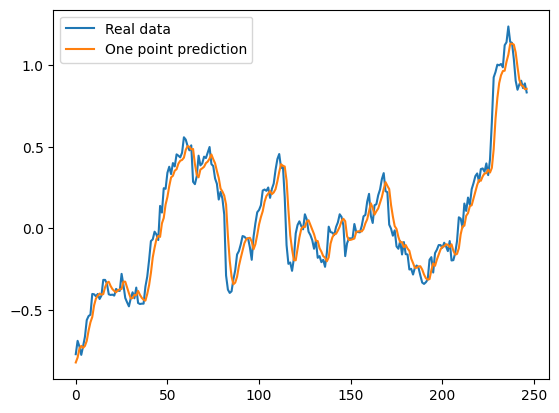

In [25]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

def preproc(data, lag, ratio):
    data=data.dropna().iloc[:, 0:1]
    Dates=data.index.unique()
    data.iloc[:, 0] = sc.fit_transform(data.iloc[:, 0].values.reshape(-1, 1))
    for s in range(1, lag + 1):
        data['shift_{}'.format(s)] = data.iloc[:, 0].shift(s)
    X_data = data.dropna().drop(['Close'], axis=1)
    y_data = data.dropna()[['Close']]
    index=int(round(len(X_data)*ratio))
    X_data_train=X_data.iloc[:index,:]
    X_data_test =X_data.iloc[index+1:,:]
    y_data_train=y_data.iloc[:index,:]
    y_data_test =y_data.iloc[index+1:,:]
    return X_data_train,X_data_test,y_data_train,y_data_test,Dates;

data = dict_tickers_history["EMBR3.SA"]
a,b,c,d,e=preproc(data, lag=7, ratio=0.90)

a.head()

a = a.values
b= b.values
c = c.values
d = d.values
# print(a.shape)
# X_train_t = a.reshape(a.shape[0], 1, 24)
# X_test_t = b.reshape(b.shape[0], 1, 24)

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import keras.backend as K
from keras.callbacks import EarlyStopping
import keras_tuner as kt
from tensorflow.keras.layers import Dropout
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters

def build_model(hp, look_back):
    model = Sequential()
    model.add(LSTM(hp.Int('input_unit',min_value=32,max_value=128,step=32),return_sequences=True, input_shape=(look_back,1)))
    for i in range(hp.Int('n_layers', 1, 10)):
        model.add(LSTM(hp.Int(f'lstm_{i}_units',min_value=32,max_value=128,step=32),return_sequences=True))
    model.add(LSTM(6))
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(Dense(6))
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam',metrics = ['mse'])
    return model

tuner= kt.RandomSearch(
        build_model,
        objective='mse',
        max_trials=10,
        executions_per_trial=3
        )

tuner.search(
        x=a,
        y=c,
        epochs=20,
        batch_size=128,
        validation_data=(b,d),
)

best_model = tuner.get_best_models(num_models=1)[0]

y_pred = best_model.predict(b)
plt.plot(d, label = "Real data")
plt.plot(y_pred, label = "One point prediction")
plt.legend()
plt.show()



In [ ]:

limiar = int(len(train) * 0.5)
X_train, y_train = split_into_X_Y_lstm(train.iloc[:limiar], max_look_back)
X_test, y_test = split_into_X_Y_lstm(train.iloc[limiar:], max_look_back)



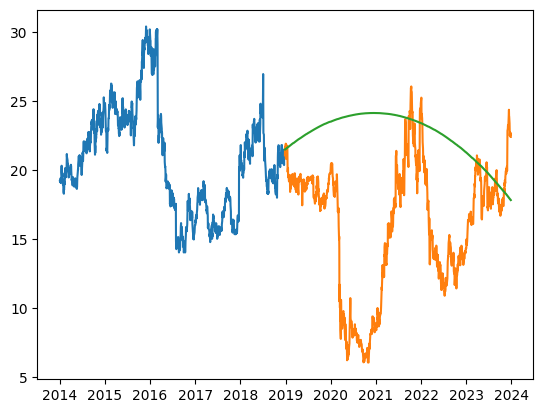

In [81]:
a = dict_train_history["EMBR3.SA"]
plt.plot(a.index, a["Close"].values)
b = dict_test_history["EMBR3.SA"]
plt.plot(b.index, b["Close"].values)
c = get_first(dict_pred_results['5 anos']["arima"])
plt.plot(c.index, c.values)
# d = get_first(dict_pred_results['1 mês']["lstm"])
# plt.plot(d.index, d.values)

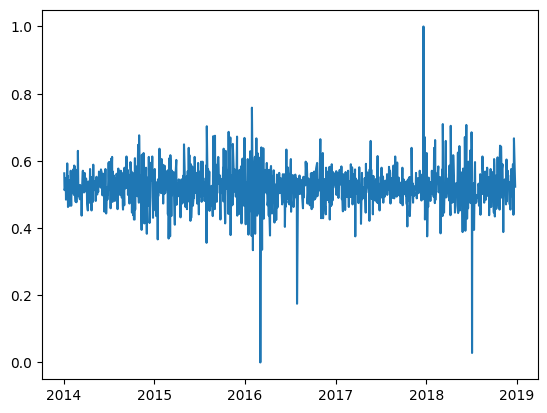

In [75]:
plt.plot(dict_train_history["EMBR3.SA"]['Normalized_Stationary_Close'].index, dict_train_history["EMBR3.SA"]['Normalized_Stationary_Close'].values)

### Analisando resultados

In [29]:
from sklearn.metrics import mean_absolute_percentage_error


def separar_test_em_periodos(history: dict) -> dict:
    h2 = {
        "1 mês": dict(),
        "3 meses": dict(),
        "6 meses": dict(),
        "1 ano": dict(),
        "3 anos": dict(),
        "5 anos": dict()
    }
    for ticker, h in history.items():
        min_date = h.index.min()
        h2["1 mês"][ticker] = filter_per_date(h, min_date, max_date=min_date + pd.DateOffset(months=1))
        h2["3 meses"][ticker] = filter_per_date(h, min_date, max_date=min_date + pd.DateOffset(months=3))
        h2["6 meses"][ticker] = filter_per_date(h, min_date, max_date=min_date + pd.DateOffset(months=6))
        h2["1 ano"][ticker] = filter_per_date(h, min_date, max_date=min_date + pd.DateOffset(years=1))
        h2["3 anos"][ticker] = filter_per_date(h, min_date, max_date=min_date + pd.DateOffset(years=3))
        h2["5 anos"][ticker] = filter_per_date(h, min_date, max_date=min_date + pd.DateOffset(years=5))
    return h2


def calculate_mapes(dict_pred_results, test_history):
    dict_mape = dict()
    for periodo, dict_modelo in dict_pred_results.items():
        for modelo, dict_ticker_name in dict_modelo.items():        
            for ticker_name, y_pred in dict_ticker_name.items():
                if not dict_mape.__contains__(periodo):
                    dict_mape[periodo] = {"arima": dict(), "lstm": dict()}
                h = test_history[ticker_name]
                h = h.loc[h.index.isin(test_history[ticker_name].index)]
                dict_mape[periodo][modelo][ticker_name] = mean_absolute_percentage_error(y_true=get_prices(h), y_pred=y_pred[:len(h)]) * 100
    return dict_mape


def calculate_mape_means(dict_pred_results, test_history):
    dict_mape_means = dict()
    for periodo, dict_modelo in calculate_mapes(dict_pred_results, test_history).items():
        for modelo, dict_ticker_name in dict_modelo.items():        
            sum = 0
            n = 0
            for _, mape in dict_ticker_name.items():
                sum += mape
                n+= 1
            if not dict_mape_means.__contains__(periodo):
                dict_mape_means[periodo] = dict()
            dict_mape_means[periodo][modelo] = float(sum / n) # media dos mapes
    return dict_mape_means


def mostrar_grafico_mapes(dict_pred_results, test_history):
    # Extrair os períodos, os valores do ARIMA e do LSTM
    for periodo, test in separar_test_em_periodos(test_history).items():
        dict_mape_means = calculate_mape_means(dict_pred_results, test)
        periodos = list(dict_mape_means.keys())
        arima_values = [dict_mape_means[periodo]['arima'] for periodo in periodos]
        lstm_values = [dict_mape_means[periodo]['lstm'] for periodo in periodos]
        
        # Configurações do gráfico
        bar_width = 0.35
        index = np.arange(len(periodos))
        
        fig, ax = plt.subplots(figsize=(10, 6))
        
        # Criar as barras
        ax.bar(index, arima_values, bar_width, label='ARIMA', color='b')
        ax.bar(index + bar_width, lstm_values, bar_width, label='LSTM', color='g')
        
        # Título e labels
        ax.set_xlabel('Períodos de treinamento')
        ax.set_ylabel('MAPE médio (%)')
        ax.set_title(f'Comparação entre ARIMA e LSTM por Período de treinamento prevendo {periodo}')
        ax.set_xticks(index + bar_width / 2)
        ax.set_xticklabels(periodos)
        ax.legend()
        
        # Exibir o gráfico
        plt.tight_layout()
        plt.show()
        
mostrar_grafico_mapes(dict_pred_results, dict_test_history)

KeyError: 'Normalized_Stationary_Close'